In [1]:
import librosa
import os
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import re
import time
import datetime

import sounddevice as sd
from scipy.io import wavfile

from multiprocess import Pool
import functools
import pdb

import sys
sys.path.insert(1, './functions_v8')

from workflow import *
from read import *
from similarity import *
from helper import *
from display import *

## Extract MIDI

In [3]:
midiPath = '../proleptic/midi-recordings/ladispute.txt'
sample_data = "Audio.wav"
global notes
notes = midi_to_timeseries(midiPath)

In [4]:
zero_penalty = 1
length_incentive = 500000 # 50 seconds yields 10% increase in score
max_offset = 600
timestamp_max_before_source = 5000 #ms behing the source timestamp
min_dist_const = 400 # acceptable time difference for same note
initial_alignment = "last note in source to match in target"
realignment = "mean offset of notes within max_offset dist - done once"
note_scoring = "penalize within min_dist"

# parameters
minNotes = 8
maxNotes = 200 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 365000
disp = False

## Musical Similarity LSH Hashing

In [5]:
def hash_func(vecs, projections):
    bools = np.dot(vecs, projections.T) > 0
    return [bool2int(bool_vec) for bool_vec in bools]

In [6]:
def bool2int(x):
    y = 0
    for i,j in enumerate(x):
        if j: y += 1<<i
    return y

In [7]:
class Table:
    
    def __init__(self, hash_size, dim):
        self.table = dict()
        self.hash_size = hash_size
        self.projections = np.random.randn(self.hash_size, dim)

    def add(self, vecs, label):
        entry = {'label': label}
        hashes = hash_func(vecs, self.projections)
        for h in hashes:
            if self.table.__contains__(h):
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, vecs):
        hashes = hash_func(vecs, self.projections)
        results = list()
        for h in hashes:
            if self.table.__contains__(h):
                results.extend(self.table[h])
        return results

In [8]:
class LSH:
    def __init__(self, dim):
        self.num_tables = 4
        self.hash_size = 8
        self.tables = list()
        for i in range(self.num_tables):
            self.tables.append(Table(self.hash_size, dim))
    
    def add(self, vecs, label):
        for table in self.tables:
            table.add(vecs, label)
    
    def query(self, vecs):
        results = list()
        for table in self.tables:
            results.extend(table.query(vecs))
        return results

    def describe(self):
        for table in self.tables:
            print(table.table)

In [9]:
class MusicSearch:
    
    def __init__(self, data_files, snip_length, scan_length):
        self.frame_size = 4096
        self.hop_size = 4000
        self.fv_size = 12
        self.msConvert = 1000
        self.lsh = LSH(self.fv_size)
        self.data_files = data_files
        self.scan_length = scan_length
        self.snip_length = int(self.data_files.shape[0] / int(self.scan_length / snip_length ))
        self.wav_midi_mult = self.scan_length * 1.0 / self.data_files.shape[0]
        self.sample_rate = self.data_files.shape[0] / ( self.scan_length * 1.0 / self.msConvert )
        self.num_features_in_file = dict()
        self.snips = 0
        for i in range(int(self.data_files.shape[0] / self.snip_length)):
            snipStart = int((self.snip_length * self.snips) * self.wav_midi_mult)
            snipEnd = int((self.snip_length * self.snips + self.snip_length) * self.wav_midi_mult)
            snipKey = "snip_start_" + str(snipStart) + "_end_" + str(snipEnd)
            self.num_features_in_file[snipKey] = 0
            self.snips += 1
                
    def load(self):
        count = 0
        for i in range(int(self.data_files.shape[0] / self.snip_length)):
            print("Snippet: ", str(count), " / ", str(int(self.data_files.shape[0] / self.snip_length)))
            features = librosa.feature.chroma_stft(self.data_files[self.snip_length*count : self.snip_length*count + self.snip_length], self.sample_rate, n_fft=self.frame_size, hop_length=self.hop_size).T
            snipStart = int((self.snip_length * count) * self.wav_midi_mult)
            snipEnd = int((self.snip_length * count + self.snip_length) * self.wav_midi_mult)
            snipKey = "snip_start_" + str(snipStart) + "_end_" + str(snipEnd)
            self.lsh.add(features, snipKey)
            self.num_features_in_file[snipKey] += len(features)
            count += 1
                
    def query(self, filepath):
        x, fs = librosa.load(filepath)
        features = librosa.feature.chroma_stft(x, fs, n_fft=self.frame_size, hop_length=self.hop_size).T
        results = self.lsh.query(features)
        # print('num results', len(results))

        counts = dict()
        for r in results:
            if counts.__contains__(r['label']):
                counts[r['label']] += 1
            else:
                counts[r['label']] = 1
        for k in counts:
            counts[k] = float(counts[k])/self.num_features_in_file[k]
        return counts

In [11]:
# snip_length: length of snippet to hash
# scan_length: length of playthrough to scan through (starting from 0)

# whole run, every 500ms 
start_time = time.time()
x, fs = librosa.load(sample_data)
ms = MusicSearch(x, snip_length=500, scan_length=734264)
ms.load()

print("\n--- Time to Load : %s seconds ---\n" % (time.time() - start_time))

Snippet:  0  /  1468
Snippet:  1  /  1468
Snippet:  2  /  1468
Snippet:  3  /  1468
Snippet:  4  /  1468
Snippet:  5  /  1468
Snippet:  6  /  1468
Snippet:  7  /  1468
Snippet:  8  /  1468
Snippet:  9  /  1468
Snippet:  10  /  1468
Snippet:  11  /  1468
Snippet:  12  /  1468
Snippet:  13  /  1468
Snippet:  14  /  1468
Snippet:  15  /  1468
Snippet:  16  /  1468
Snippet:  17  /  1468
Snippet:  18  /  1468
Snippet:  19  /  1468
Snippet:  20  /  1468
Snippet:  21  /  1468
Snippet:  22  /  1468
Snippet:  23  /  1468
Snippet:  24  /  1468
Snippet:  25  /  1468
Snippet:  26  /  1468
Snippet:  27  /  1468
Snippet:  28  /  1468
Snippet:  29  /  1468
Snippet:  30  /  1468
Snippet:  31  /  1468
Snippet:  32  /  1468
Snippet:  33  /  1468
Snippet:  34  /  1468
Snippet:  35  /  1468
Snippet:  36  /  1468
Snippet:  37  /  1468
Snippet:  38  /  1468
Snippet:  39  /  1468
Snippet:  40  /  1468
Snippet:  41  /  1468
Snippet:  42  /  1468
Snippet:  43  /  1468
Snippet:  44  /  1468
Snippet:  45  /  146

/Users/pmuthu/miniforge3/envs/stagecast/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


Snippet:  424  /  1468
Snippet:  425  /  1468
Snippet:  426  /  1468
Snippet:  427  /  1468
Snippet:  428  /  1468
Snippet:  429  /  1468
Snippet:  430  /  1468
Snippet:  431  /  1468
Snippet:  432  /  1468
Snippet:  433  /  1468
Snippet:  434  /  1468
Snippet:  435  /  1468
Snippet:  436  /  1468
Snippet:  437  /  1468
Snippet:  438  /  1468
Snippet:  439  /  1468
Snippet:  440  /  1468
Snippet:  441  /  1468
Snippet:  442  /  1468
Snippet:  443  /  1468
Snippet:  444  /  1468
Snippet:  445  /  1468
Snippet:  446  /  1468
Snippet:  447  /  1468
Snippet:  448  /  1468
Snippet:  449  /  1468
Snippet:  450  /  1468
Snippet:  451  /  1468
Snippet:  452  /  1468
Snippet:  453  /  1468
Snippet:  454  /  1468
Snippet:  455  /  1468
Snippet:  456  /  1468
Snippet:  457  /  1468
Snippet:  458  /  1468
Snippet:  459  /  1468
Snippet:  460  /  1468
Snippet:  461  /  1468
Snippet:  462  /  1468
Snippet:  463  /  1468
Snippet:  464  /  1468
Snippet:  465  /  1468
Snippet:  466  /  1468
Snippet:  4

In [15]:
# snip_length: length of snippet to hash
# scan_length: length of playthrough to scan through (starting from 0)

# whole run, every 500ms 
start_time = time.time()
x, fs = librosa.load(sample_data)
ms = MusicSearch(x, snip_length=100, scan_length=734264)
ms.load()

print("\n--- Time to Load : %s seconds ---\n" % (time.time() - start_time))

Snippet:  0  /  7342
Snippet:  1  /  7342
Snippet:  2  /  7342
Snippet:  3  /  7342
Snippet:  4  /  7342
Snippet:  5  /  7342
Snippet:  6  /  7342
Snippet:  7  /  7342
Snippet:  8  /  7342
Snippet:  9  /  7342
Snippet:  10  /  7342
Snippet:  11  /  7342
Snippet:  12  /  7342
Snippet:  13  /  7342
Snippet:  14  /  7342
Snippet:  15  /  7342
Snippet:  16  /  7342
Snippet:  17  /  7342
Snippet:  18  /  7342
Snippet:  19  /  7342
Snippet:  20  /  7342
Snippet:  21  /  7342
Snippet:  22  /  7342
Snippet:  23  /  7342
Snippet:  24  /  7342
Snippet:  25  /  7342
Snippet:  26  /  7342
Snippet:  27  /  7342
Snippet:  28  /  7342
Snippet:  29  /  7342
Snippet:  30  /  7342
Snippet:  31  /  7342
Snippet:  32  /  7342
Snippet:  33  /  7342
Snippet:  34  /  7342
Snippet:  35  /  7342
Snippet:  36  /  7342
Snippet:  37  /  7342
Snippet:  38  /  7342
Snippet:  39  /  7342
Snippet:  40  /  7342
Snippet:  41  /  7342
Snippet:  42  /  7342
Snippet:  43  /  7342
Snippet:  44  /  7342
Snippet:  45  /  734

/Users/pmuthu/miniforge3/envs/stagecast/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=4096 is too small for input signal of length=2220
  return f(*args, **kwargs)


Snippet:  88  /  7342
Snippet:  89  /  7342
Snippet:  90  /  7342
Snippet:  91  /  7342
Snippet:  92  /  7342
Snippet:  93  /  7342
Snippet:  94  /  7342
Snippet:  95  /  7342
Snippet:  96  /  7342
Snippet:  97  /  7342
Snippet:  98  /  7342
Snippet:  99  /  7342
Snippet:  100  /  7342
Snippet:  101  /  7342
Snippet:  102  /  7342
Snippet:  103  /  7342
Snippet:  104  /  7342
Snippet:  105  /  7342
Snippet:  106  /  7342
Snippet:  107  /  7342
Snippet:  108  /  7342
Snippet:  109  /  7342
Snippet:  110  /  7342
Snippet:  111  /  7342
Snippet:  112  /  7342
Snippet:  113  /  7342
Snippet:  114  /  7342
Snippet:  115  /  7342
Snippet:  116  /  7342
Snippet:  117  /  7342
Snippet:  118  /  7342
Snippet:  119  /  7342
Snippet:  120  /  7342
Snippet:  121  /  7342
Snippet:  122  /  7342
Snippet:  123  /  7342
Snippet:  124  /  7342
Snippet:  125  /  7342
Snippet:  126  /  7342
Snippet:  127  /  7342
Snippet:  128  /  7342
Snippet:  129  /  7342
Snippet:  130  /  7342
Snippet:  131  /  7342


In [16]:
# snip_length: length of snippet to hash
# scan_length: length of playthrough to scan through (starting from 0)

# whole run, every 500ms 
start_time = time.time()
x, fs = librosa.load(sample_data)
ms = MusicSearch(x, snip_length=10, scan_length=734264)
ms.load()

print("\n--- Time to Load : %s seconds ---\n" % (time.time() - start_time))

Snippet:  0  /  73752
Snippet:  1  /  73752
Snippet:  2  /  73752
Snippet:  3  /  73752
Snippet:  4  /  73752
Snippet:  5  /  73752
Snippet:  6  /  73752
Snippet:  7  /  73752
Snippet:  8  /  73752
Snippet:  9  /  73752
Snippet:  10  /  73752
Snippet:  11  /  73752
Snippet:  12  /  73752
Snippet:  13  /  73752
Snippet:  14  /  73752
Snippet:  15  /  73752
Snippet:  16  /  73752
Snippet:  17  /  73752
Snippet:  18  /  73752
Snippet:  19  /  73752
Snippet:  20  /  73752
Snippet:  21  /  73752
Snippet:  22  /  73752
Snippet:  23  /  73752
Snippet:  24  /  73752
Snippet:  25  /  73752
Snippet:  26  /  73752
Snippet:  27  /  73752
Snippet:  28  /  73752
Snippet:  29  /  73752
Snippet:  30  /  73752
Snippet:  31  /  73752
Snippet:  32  /  73752
Snippet:  33  /  73752
Snippet:  34  /  73752
Snippet:  35  /  73752
Snippet:  36  /  73752
Snippet:  37  /  73752
Snippet:  38  /  73752
Snippet:  39  /  73752
Snippet:  40  /  73752
Snippet:  41  /  73752
Snippet:  42  /  73752
Snippet:  43  /  7375

/Users/pmuthu/miniforge3/envs/stagecast/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=4096 is too small for input signal of length=221
  return f(*args, **kwargs)


Snippet:  69  /  73752
Snippet:  70  /  73752
Snippet:  71  /  73752
Snippet:  72  /  73752
Snippet:  73  /  73752
Snippet:  74  /  73752
Snippet:  75  /  73752
Snippet:  76  /  73752
Snippet:  77  /  73752
Snippet:  78  /  73752
Snippet:  79  /  73752
Snippet:  80  /  73752
Snippet:  81  /  73752
Snippet:  82  /  73752
Snippet:  83  /  73752
Snippet:  84  /  73752
Snippet:  85  /  73752
Snippet:  86  /  73752
Snippet:  87  /  73752
Snippet:  88  /  73752
Snippet:  89  /  73752
Snippet:  90  /  73752
Snippet:  91  /  73752
Snippet:  92  /  73752
Snippet:  93  /  73752
Snippet:  94  /  73752
Snippet:  95  /  73752
Snippet:  96  /  73752
Snippet:  97  /  73752
Snippet:  98  /  73752
Snippet:  99  /  73752
Snippet:  100  /  73752
Snippet:  101  /  73752
Snippet:  102  /  73752
Snippet:  103  /  73752
Snippet:  104  /  73752
Snippet:  105  /  73752
Snippet:  106  /  73752
Snippet:  107  /  73752
Snippet:  108  /  73752
Snippet:  109  /  73752
Snippet:  110  /  73752
Snippet:  111  /  73752

In [12]:
source_file = './source/source_from_220462_to_250000.wav'
sourceStart = 220462
sourceEnd = 250000
results = ms.query(source_file)

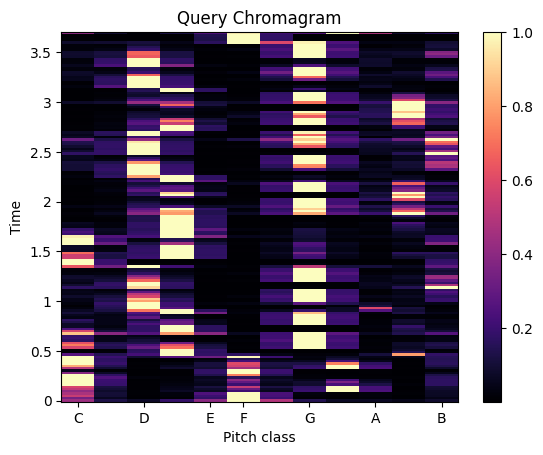

In [13]:
import librosa.display
x, fs = librosa.load(source_file)
features = librosa.feature.chroma_stft(x, fs, n_fft=4000, hop_length=4096).T

fig, ax = plt.subplots()
img = librosa.display.specshow(features, y_axis='time', x_axis='chroma', ax=ax)
ax.set(title='Query Chromagram')
fig.colorbar(img, ax=ax)

In [14]:
import re
targetStarts = []
targetEnds = []
res = []

for r in sorted(results, key=results.get, reverse=True):
    print(r, results[r])
    targetStarts.append(int(re.findall(r'\d+', r)[0]))
    targetEnds.append(int(re.findall(r'\d+', r)[1]))
    res.append(int(results[r]))

snip_start_1500_end_2000 164.33333333333334
snip_start_76526_end_77026 164.33333333333334
snip_start_433151_end_433651 164.33333333333334
snip_start_450657_end_451157 164.33333333333334
snip_start_57019_end_57520 163.66666666666666
snip_start_256089_end_256589 163.66666666666666
snip_start_316610_end_317110 163.66666666666666
snip_start_445655_end_446156 163.66666666666666
snip_start_596708_end_597209 163.66666666666666
snip_start_626219_end_626719 163.66666666666666
snip_start_257590_end_258090 163.0
snip_start_604211_end_604711 163.0
snip_start_416645_end_417145 158.66666666666666
snip_start_13504_end_14004 158.0
snip_start_67023_end_67523 158.0
snip_start_238083_end_238583 158.0
snip_start_453658_end_454158 158.0
snip_start_590206_end_590706 158.0
snip_start_255589_end_256089 155.66666666666666
snip_start_431651_end_432151 154.0
snip_start_204071_end_204571 153.66666666666666
snip_start_6502_end_7002 153.33333333333334
snip_start_247086_end_247586 153.0
snip_start_245085_end_245585 